In [49]:
import os, glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from country_converter import CountryConverter

sns.set(style="whitegrid")
%matplotlib inline

In [ ]:
years = list(range(2015, 2020))
files = {}
for y in years:
    candidates = []
    for ext in ("csv", "xlsx", "xls"):
        candidates.extend(glob.glob(f"{y}*.{ext}"))
        candidates.extend(glob.glob(f"*{y}*.{ext}"))
    candidates = sorted(set(candidates), key=lambda p: (len(p), p.lower()))
    if candidates:
        files[y] = candidates[0]
    else:
        print(f"Warning: No file found for {y} in this folder.")

In [ ]:
COLUMN_OPTIONS = {
    "Country": ["Country", "Country or region", "Country/Region", "Country name"],
    "Happiness Score": ["Happiness Score", "Score", "Happiness.Score"],
    "GDP per capita": ["GDP per capita", "Economy (GDP per Capita)", "Economy..GDP.per.Capita."],
    "Social support": ["Social support", "Family"],
    "Healthy life expectancy": ["Healthy life expectancy", "Health (Life Expectancy)", "Health..Life.Expectancy."],
    "Freedom": ["Freedom", "Freedom to make life choices"],
    "Generosity": ["Generosity"],
    "Perceptions of corruption": [
        "Perceptions of corruption",
        "Trust (Government Corruption)",
        "Trust..Government.Corruption.",
        "Perception of corruption"
    ],
    "Region": ["Region"],
}
NUMERIC_COLS = [
    "Happiness Score",
    "GDP per capita",
    "Social support",
    "Healthy life expectancy",
    "Freedom",
    "Generosity",
    "Perceptions of corruption",
]

In [52]:
def load_and_standardize(path: str, year: int) -> pd.DataFrame:
    if path.lower().endswith((".xlsx", ".xls")):
        df = pd.read_excel(path)
    else:
        df = pd.read_csv(path)
    df.columns = [str(c).strip() for c in df.columns]

    out = pd.DataFrame()
    for new_col, options in COLUMN_OPTIONS.items():
        for opt in options:
            if opt in df.columns:
                out[new_col] = df[opt]
                break

    out["Year"] = year

    # Ensure numeric
    for col in NUMERIC_COLS:
        if col in out.columns:
            out[col] = pd.to_numeric(out[col], errors="coerce")

    if "Country" in out.columns:
        out["Country"] = out["Country"].astype(str).str.strip()

    return out

In [ ]:
cc = CountryConverter()
data_by_year = {}
for y, path in files.items():
    d = load_and_standardize(path, y)
    if "Country" in d.columns:
        d["Continent"] = cc.convert(names=d["Country"].tolist(), to="continent", not_found=None)
        d["Continent"] = d["Continent"].fillna("Unknown")
    data_by_year[y] = d

if data_by_year:
    df_all = pd.concat(data_by_year.values(), ignore_index=True, sort=False)
    df_all["Continent"] = df_all.get("Continent", pd.Series(index=df_all.index)).fillna("Unknown")
else:
    df_all = pd.DataFrame()

for y in sorted(data_by_year.keys()):
    d = data_by_year[y]
    print(f"{y}: {d.shape[0]} rows, columns: {sorted(list(d.columns))}")
print("Combined:", df_all.shape)

2015: 158 rows, columns: ['Continent', 'Country', 'Freedom', 'GDP per capita', 'Generosity', 'Happiness Score', 'Healthy life expectancy', 'Perceptions of corruption', 'Region', 'Social support', 'Year']
2016: 157 rows, columns: ['Continent', 'Country', 'Freedom', 'GDP per capita', 'Generosity', 'Happiness Score', 'Healthy life expectancy', 'Perceptions of corruption', 'Region', 'Social support', 'Year']
2017: 155 rows, columns: ['Continent', 'Country', 'Freedom', 'GDP per capita', 'Generosity', 'Happiness Score', 'Healthy life expectancy', 'Perceptions of corruption', 'Social support', 'Year']
2018: 156 rows, columns: ['Continent', 'Country', 'Freedom', 'GDP per capita', 'Generosity', 'Happiness Score', 'Healthy life expectancy', 'Perceptions of corruption', 'Social support', 'Year']
2019: 156 rows, columns: ['Continent', 'Country', 'Freedom', 'GDP per capita', 'Generosity', 'Happiness Score', 'Healthy life expectancy', 'Perceptions of corruption', 'Social support', 'Year']
Combined: 

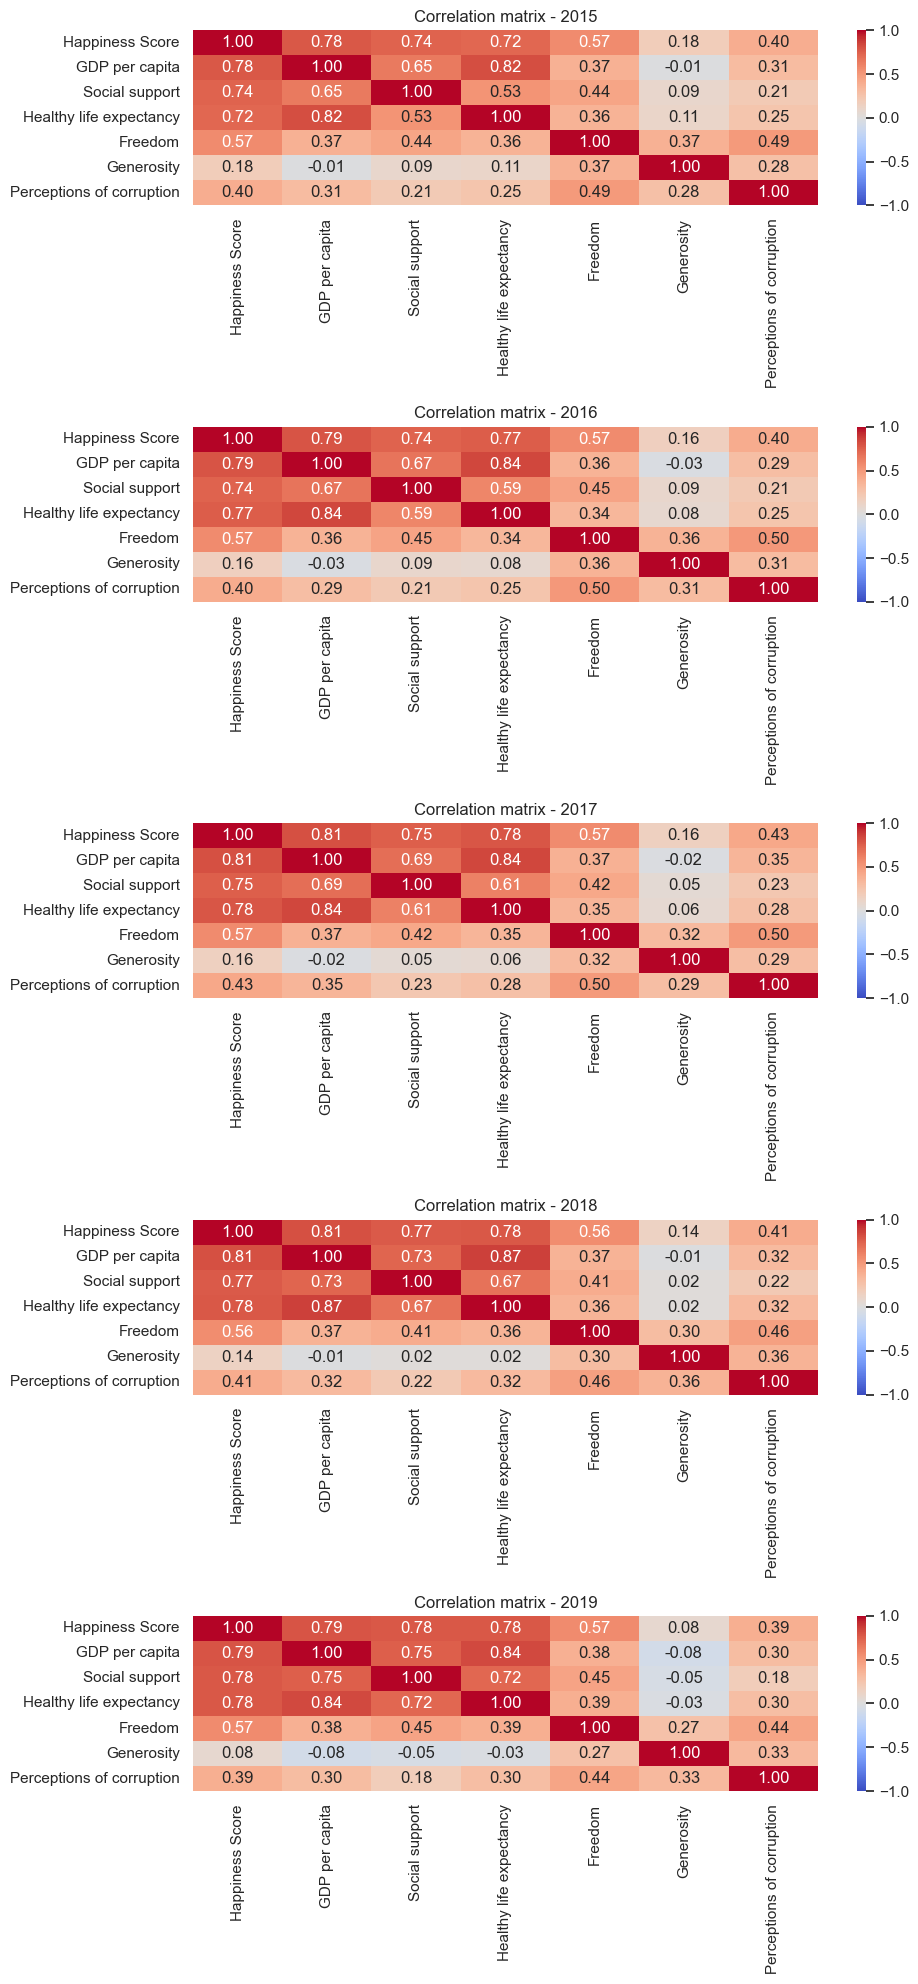

In [ ]:
years_sorted = sorted(data_by_year.keys())

fig, axes = plt.subplots(nrows=len(years_sorted), ncols=1, figsize=(10, 4*len(years_sorted)))
if len(years_sorted) == 1:
    axes = [axes]
for ax, y in zip(axes, years_sorted):
    d = data_by_year[y]
    corr = d[ [c for c in NUMERIC_COLS if c in d.columns] ].dropna().corr()
    sns.heatmap(corr, ax=ax, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
    ax.set_title(f"Correlation matrix - {y}")
plt.tight_layout()
plt.show()

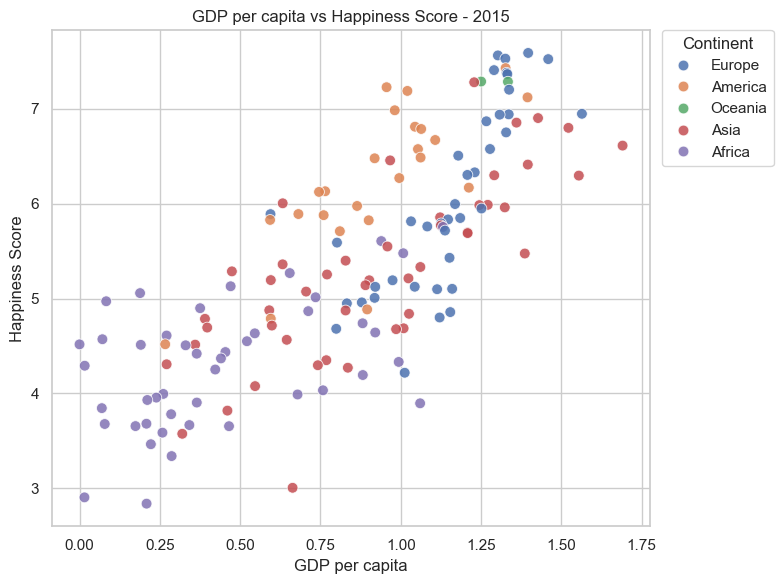

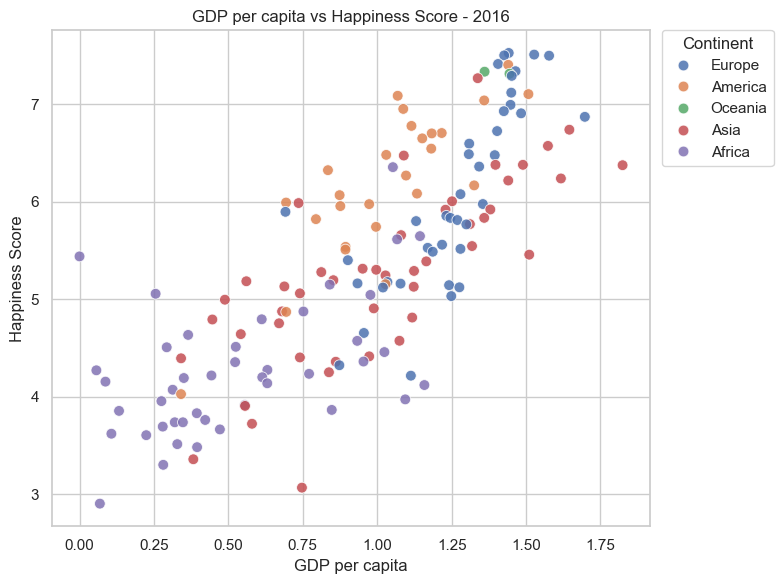

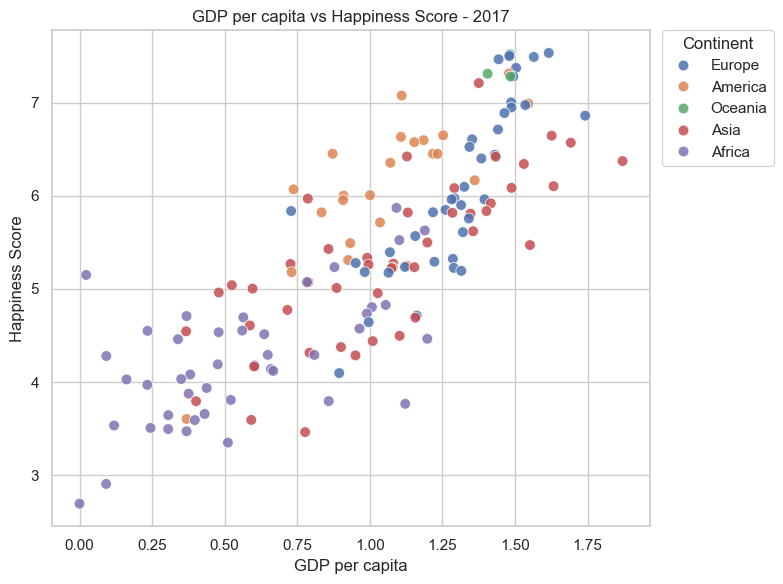

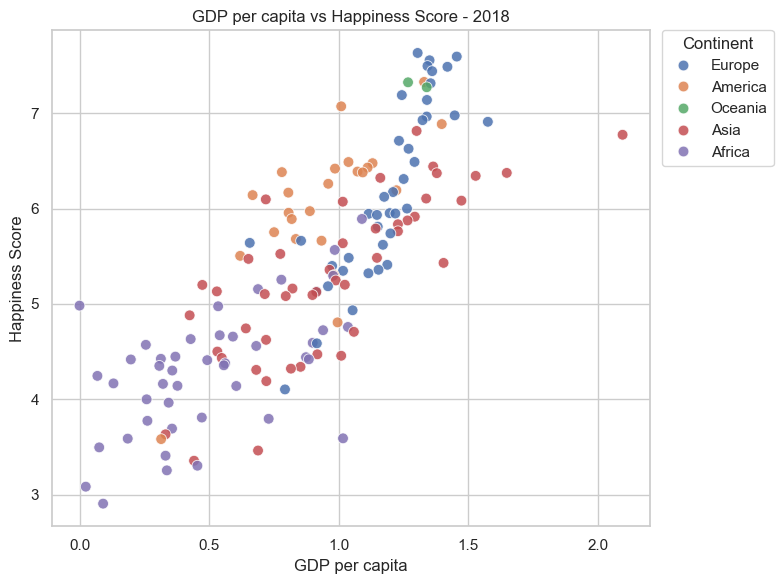

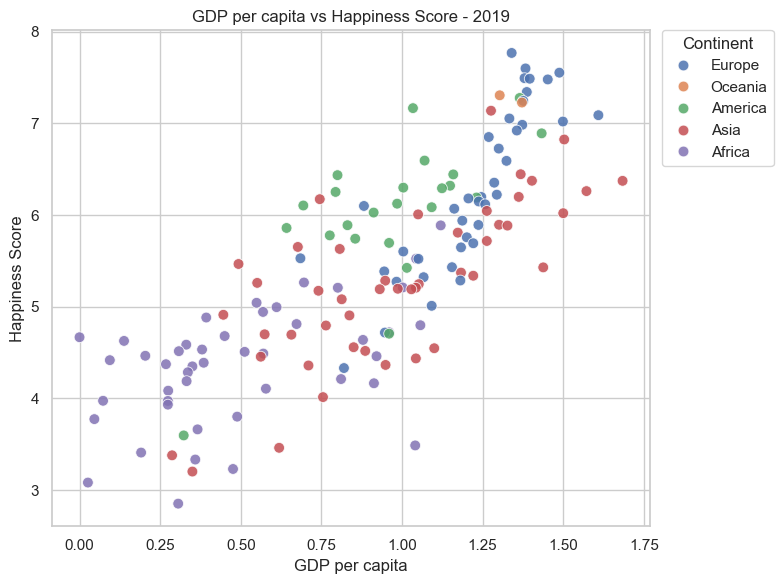

In [ ]:
for y in years_sorted:
    d = data_by_year[y]
    if ("GDP per capita" not in d.columns) or ("Happiness Score" not in d.columns):
        continue
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=d, x="GDP per capita", y="Happiness Score", hue=d.get("Continent", pd.Series(index=d.index)),
        s=60, alpha=0.85
    )
    plt.title(f"GDP per capita vs Happiness Score - {y}")
    plt.xlabel("GDP per capita")
    plt.ylabel("Happiness Score")
    plt.legend(title="Continent", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)
    plt.tight_layout()
    plt.show()

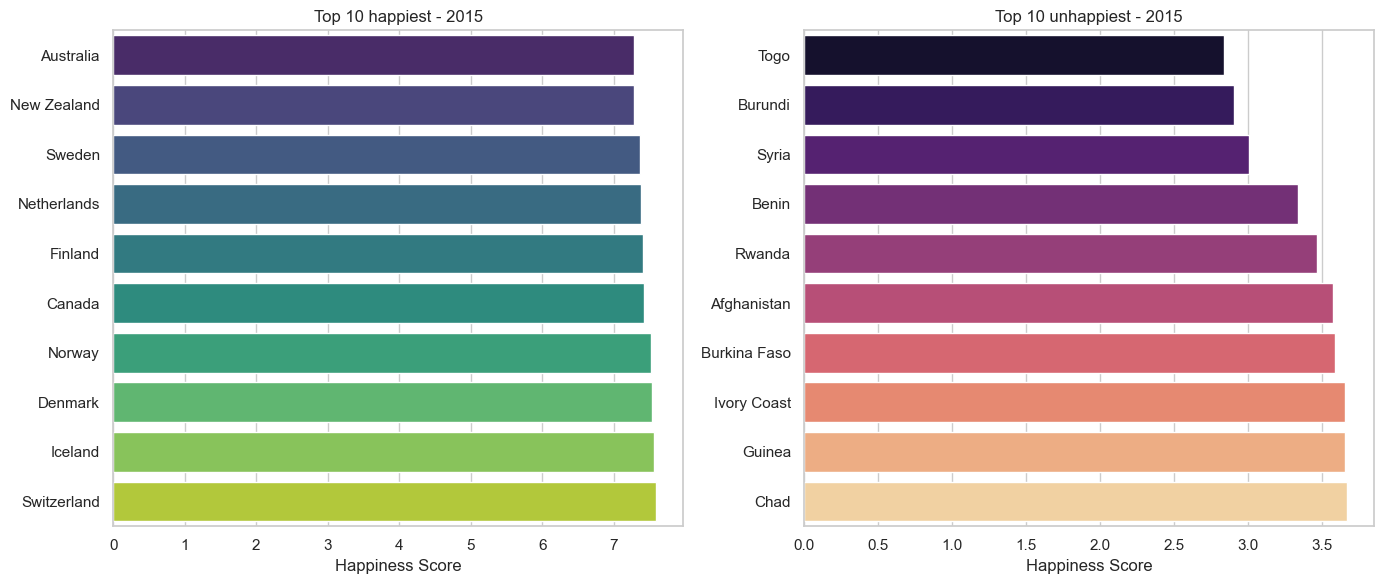

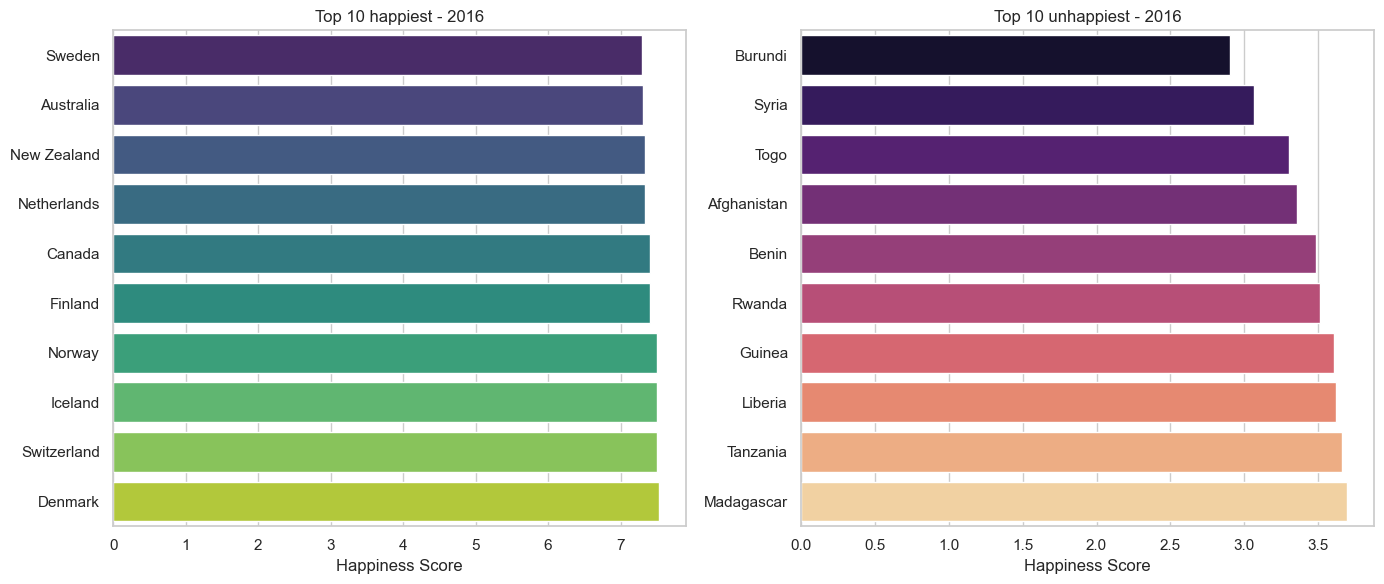

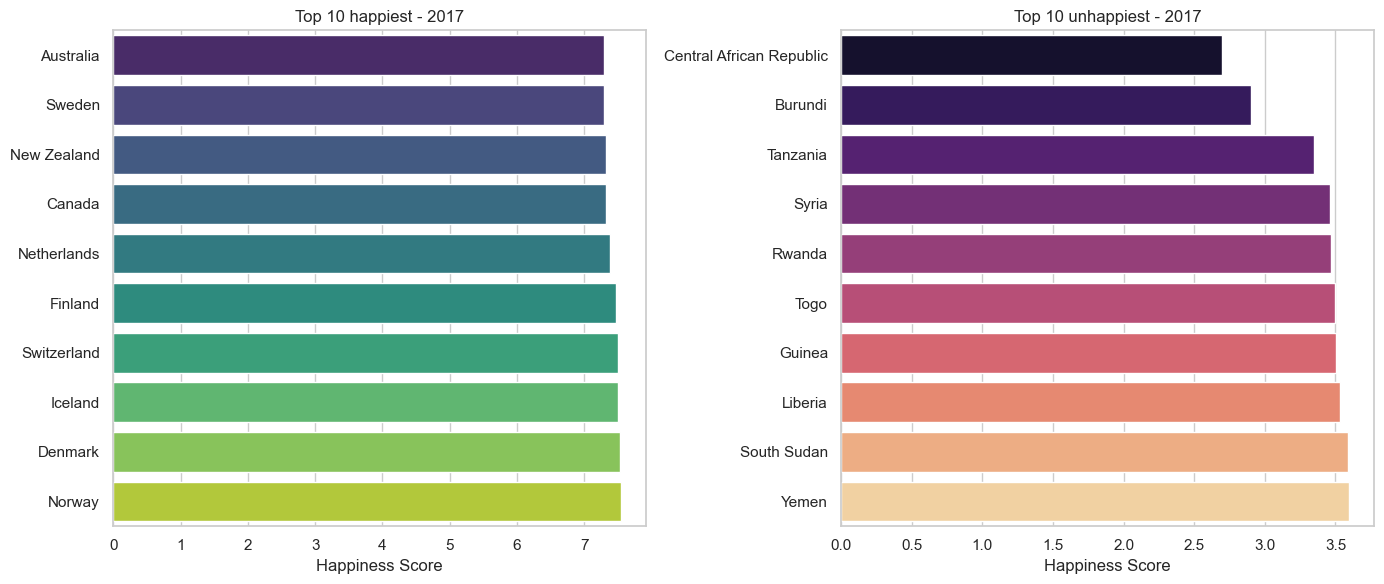

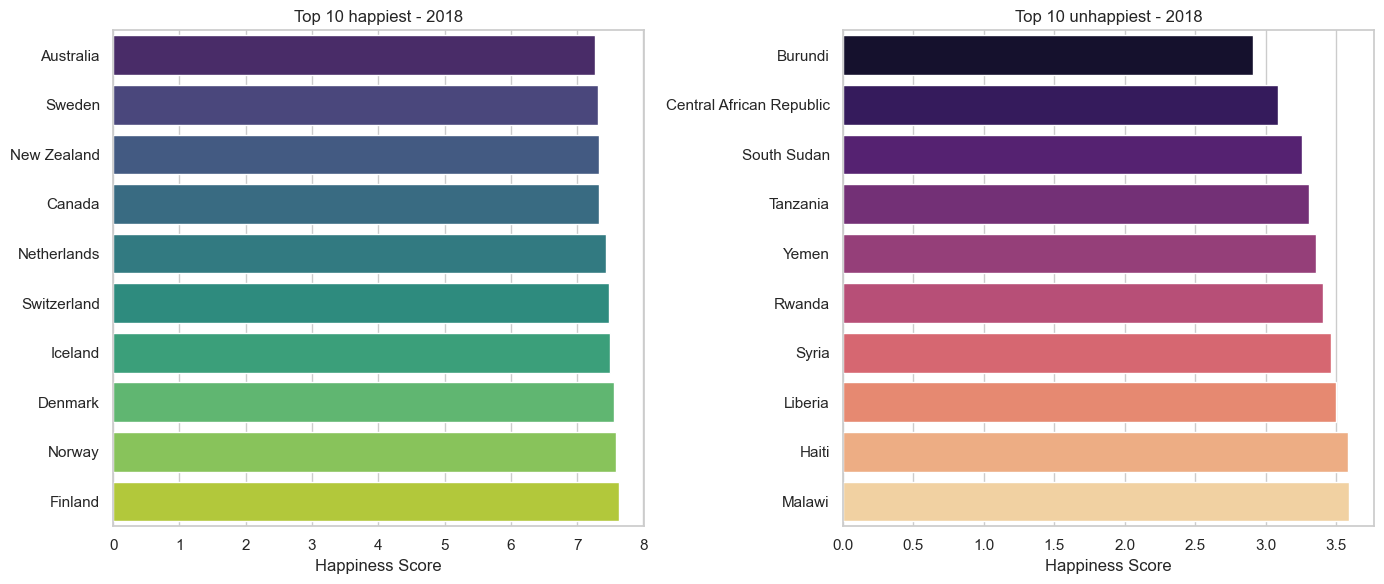

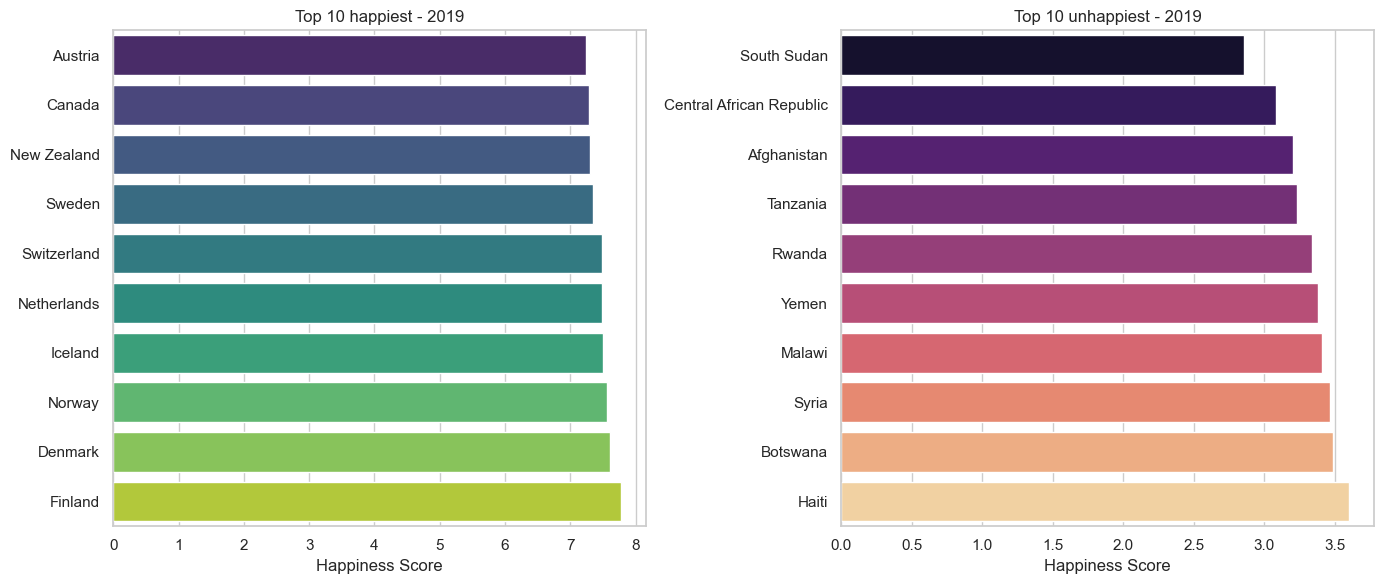

In [ ]:
for y in years_sorted:
    d = data_by_year[y].dropna(subset=["Happiness Score"]).copy()
    if d.empty:
        continue
    top10 = d.nlargest(10, "Happiness Score")
    bottom10 = d.nsmallest(10, "Happiness Score")

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    sns.barplot(
        data=top10.sort_values("Happiness Score"),
        x="Happiness Score",
        y="Country",
        hue="Country",
        dodge=False,
        legend=False,
        palette="viridis",
        ax=axes[0]
    )
    axes[0].set_title(f"Top 10 happiest - {y}")
    axes[0].set_xlabel("Happiness Score")
    axes[0].set_ylabel("")

    sns.barplot(
        data=bottom10.sort_values("Happiness Score"),
        x="Happiness Score",
        y="Country",
        hue="Country",
        dodge=False,
        legend=False,
        palette="magma",
        ax=axes[1]
    )
    axes[1].set_title(f"Top 10 unhappiest - {y}")
    axes[1].set_xlabel("Happiness Score")
    axes[1].set_ylabel("")

    plt.tight_layout()
    plt.show()


In [ ]:
for y in years_sorted:
    d = data_by_year[y].dropna(subset=["Country", "Happiness Score"]).copy()
    if d.empty:
        continue
    title = f"Bubble map of Happiness Score - {y}"
    fig = px.scatter_geo(
        d,
        locations="Country",
        locationmode="country names",
        size="Happiness Score",
        color=d.get("Continent", pd.Series(index=d.index)),
        hover_name="Country",
        hover_data={"Happiness Score":":.2f", "GDP per capita":":.2f"} if "GDP per capita" in d.columns else {"Happiness Score":":.2f"},
        projection="natural earth",
        title=title,
    )
    fig.update_layout(height=500)
    fig.show()

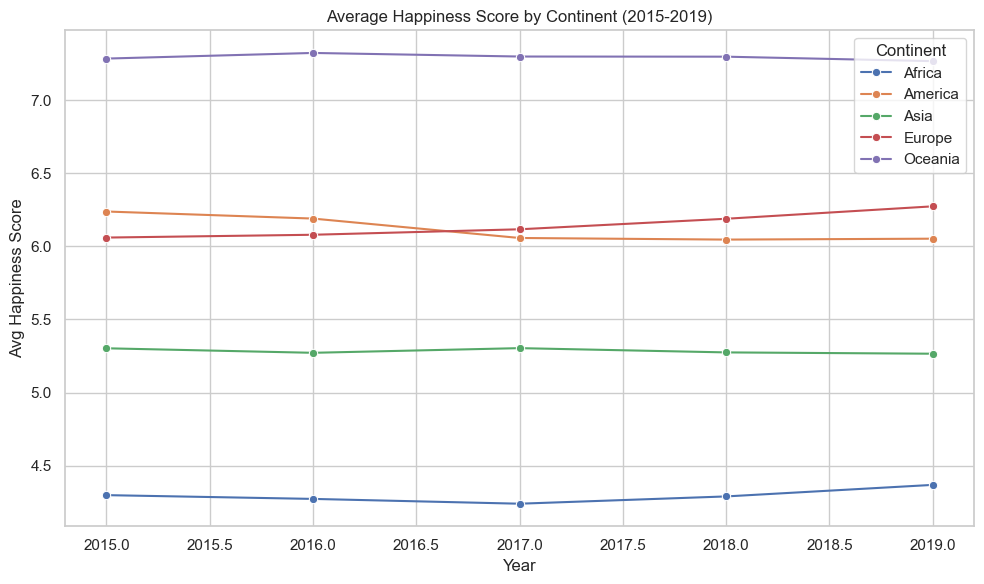

In [ ]:
if df_all.empty:
    raise SystemExit("Combined dataframe is empty.")

if {"Year", "Continent", "Happiness Score"}.issubset(df_all.columns):
    avg_by_cont = (
        df_all.dropna(subset=["Happiness Score"]).groupby(["Year", "Continent"], as_index=False)["Happiness Score"].mean()
    )
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=avg_by_cont, x="Year", y="Happiness Score", hue="Continent", marker="o")
    plt.title("Average Happiness Score by Continent (2015-2019)")
    plt.xlabel("Year")
    plt.ylabel("Avg Happiness Score")
    plt.tight_layout()
    plt.show()

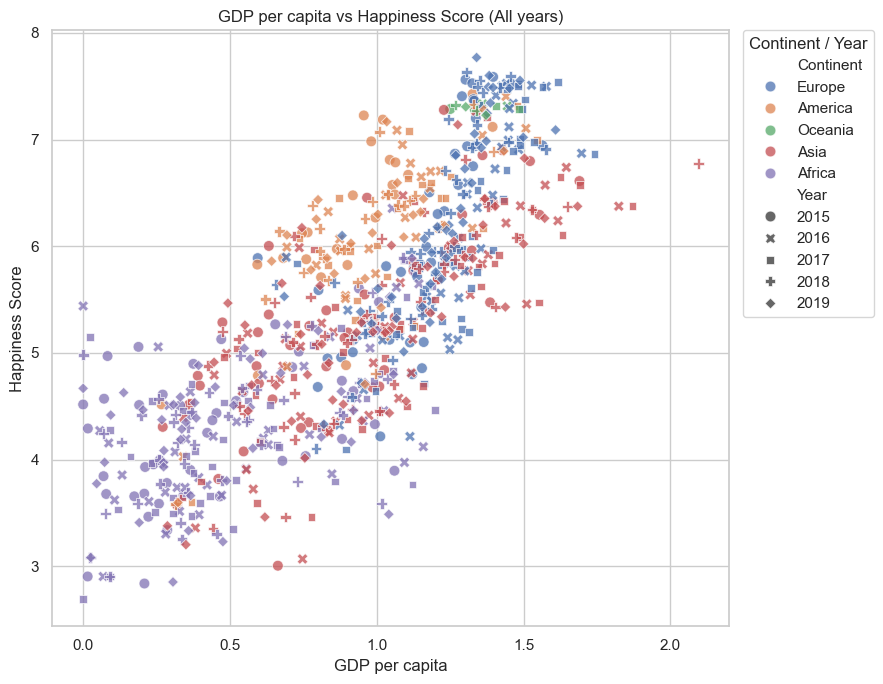

In [ ]:
if {"GDP per capita", "Happiness Score"}.issubset(df_all.columns):
    plt.figure(figsize=(9, 7))
    sns.scatterplot(
        data=df_all, x="GDP per capita", y="Happiness Score",
        hue=df_all.get("Continent", pd.Series(index=df_all.index)), style="Year",
        s=60, alpha=0.75
    )
    plt.title("GDP per capita vs Happiness Score (All years)")
    plt.xlabel("GDP per capita")
    plt.ylabel("Happiness Score")
    plt.legend(title="Continent / Year", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)
    plt.tight_layout()
    plt.show()

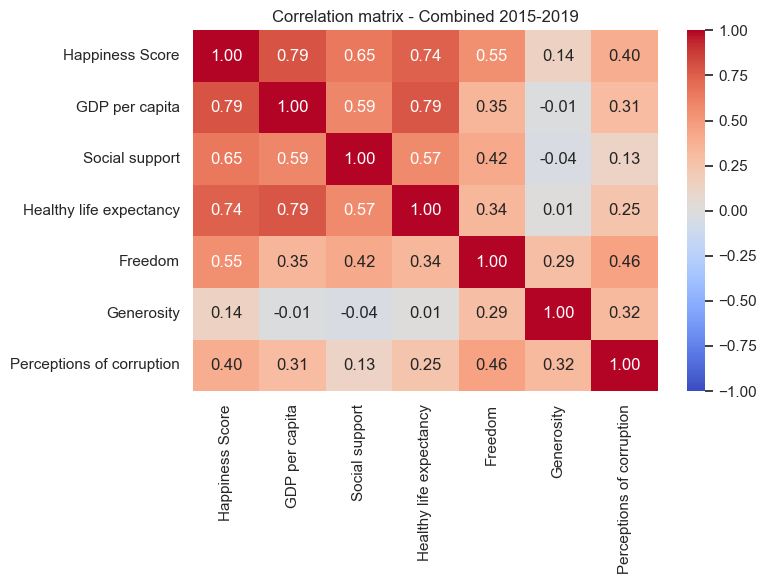

In [ ]:
cols_present = [c for c in NUMERIC_COLS if c in df_all.columns]
if cols_present:
    corr = df_all[cols_present].dropna().corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
    plt.title("Correlation matrix - Combined 2015-2019")
    plt.tight_layout()
    plt.show()